# How Have Marriages Changed Over the Years?

A friend of my wife’s is a dating coach in Poland, and they were wondering what the true marriage trends in their home country was and if it reflects ever popular notions that people are marrying later in life, and the importance of marriage is changing overall. Since she is called to help people navigate relationships, she desires to have a clear and accurate understanding of how dating habits are changing.

Being a typical engineer and always interested in solving a problem, I dived into researching the topic and found that there were quite a few detailed data sets available to shed some light on this topic. A few of the main metrics used to gauge marriage trends are the crude marriage rate (CMR) to show how often people are getting married. There is the average age at the time of marriage to track when in life people are considering marriage. Lastly, we have the means to explore the number of marriages by age group, providing a detailed view of which stage in life is the most popular time to get married.


If you are more interested in reading the analysis and wish to skip the intermediate coding, [click here](#Analysis)!

# What Data is Available?

I investigated and found that the readily available data from two  resources:

1. [Eurostat](https://ec.europa.eu/eurostat/web/main/home) - Provides and harmonizes statistics across member states of the European Union
2. [BDL](https://bdl.stat.gov.pl/bdl/start) - The Local Data Bank (BDL). Poland's largest database for national metrics

From BDLwe can get the number of marriages by the age grouping of the bride and groom over the last 14 years and the total population of Poland since 2005. Pulling this data will allow us to calculate some metrics for our analysis.

From Eurostat, we downloaded the European Union's crude marriage rate to serve as a benchmark to compare the trends in Poland and the total number of marriages at each age of both groom and bride for each year. We pulled this data in order to 
 

## Loading the Data

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

plt.style.use('./assets/executive_report.mplstyle')

In [48]:
df_female = pd.read_csv('data/bride age group.csv', sep=';')
df_male = pd.read_csv('data/groom age group.csv', sep=';')
df_total_marriages = pd.read_csv('data/marriages_contracted_per_year.csv', sep=';')
df_pop = pd.read_csv('data/poland_population_2005.csv', sep=';') 
df_eu_cmr = pd.read_csv('data/tps00206 EU CMR 2001.csv')
df_sing_age = pd.read_csv('data/poland_marriages_by_age_gender_year.csv')
df_population_age = pd.read_csv('data/poland_ages_by_year.csv')


# Data Wrangling

### Marriages by Age Group

The BDl website, had difficulty exporting the marriage data for both men and women, so they were downloaded separately and we will concatenate them here. For our data cleaning we will drop unnecessary columns and rename the columns and check for any null values.

In [49]:
print('Null Values')
print('Dataset for Women')
print(df_female.isna().sum())
print('\nDataset for Men')
print(df_male.isna().sum())

Null Values
Dataset for Women
Code                    0
Name                    0
Location                0
Types of marriages      0
Age of females          0
Age of males            0
Year                    0
Value                   0
Measure Unit            0
Attribute             126
Unnamed: 10           126
dtype: int64

Dataset for Men
Code                    0
Name                    0
Location                0
Types of marriages      0
Age of females          0
Age of males            0
Year                    0
Value                   0
Measure Unit            0
Attribute             126
Unnamed: 10           126
dtype: int64


In [50]:
# Denoting gender for each data set
df_female['gender'] = 'female'
df_male['gender'] = 'male'

# Dropping the rows representing total marriages regardless of age group 
df_female = df_female[df_female['Age of females'] != 'females total']
df_male = df_male[df_male['Age of males'] != 'males total']

# Dropping the columns listing the opposite genders age, which is simply the total number in this case
df_female.drop(columns='Age of males', inplace=True)
df_male.drop(columns='Age of females', inplace=True)

# Rename to age group
df_female.rename(columns={'Age of females' : 'age group'}, inplace=True)
df_male.rename(columns={'Age of males' : 'age group'}, inplace=True)

# Concatenating and dropping unnecessary columns
df_marriage = pd.concat([df_male, df_female], axis=0)
df_marriage.drop(
    columns=['Code','Name', 'Location', 'Types of marriages', 'Measure Unit', 'Attribute', 'Unnamed: 10'],
    inplace=True)

del(df_female, df_male)

df_marriage.head(5)

,age group,Year,Value,gender
14,under 20 years,2010,1320,male
15,under 20 years,2011,1090,male
16,under 20 years,2012,911,male
17,under 20 years,2013,716,male
18,under 20 years,2014,619,male


Our friend specified that she focus on helping young adults in their twenties to thirties, so we will group ages past 40 into a single age group to keep the analysis focused. 

In [51]:
new_age_dict = {
    'under 20 years' : '<20',
    '40-49' : '+40',
    '50-59' : '+40',
    '60 and more' : '+40'
}

df_marriage['age group'].replace(new_age_dict, inplace= True)
df_marriage = df_marriage.groupby(['Year', 'gender', 'age group'])['Value'].sum().reset_index()
df_marriage.head(6)

,Year,gender,age group,Value
0,2010,female,+40,13816
1,2010,female,20-24,79746
2,2010,female,25-29,89646
3,2010,female,30-34,26972
4,2010,female,35-39,9150
5,2010,female,<20,9007


To support the analysis, we will calculate the percentage contribution of each age group to the total number of marriages each year, as well as rank the age groups accordingly.

In [52]:
df_marriage['percent of total'] = df_marriage['Value'] / df_marriage.groupby(['Year', 'gender'])['Value'].transform('sum')
df_marriage['rank'] = df_marriage.groupby(['Year', 'gender'])['Value'].rank(ascending=False)
df_marriage.head(12)


,Year,gender,age group,Value,percent of total,rank
0,2010,female,+40,13816,0.060507,4.0
1,2010,female,20-24,79746,0.349247,2.0
2,2010,female,25-29,89646,0.392604,1.0
3,2010,female,30-34,26972,0.118124,3.0
4,2010,female,35-39,9150,0.040072,5.0
5,2010,female,<20,9007,0.039446,6.0
6,2010,male,+40,20041,0.087769,4.0
7,2010,male,20-24,44683,0.195689,2.0
8,2010,male,25-29,103417,0.452914,1.0
9,2010,male,30-34,44104,0.193153,3.0


### Total Marriages by Year

Moving onto our next data set, total marriages in, the handling of this data is straightforward. We will only need to extract the 'Year' column and 'Value' column (the total number of marriages)

In [53]:
df_total_marriages = df_total_marriages.loc[:, ['Year','Value']]
df_total_marriages.head(5)

,Year,Value
0,1995,207081
1,1996,203641
2,1997,204850
3,1998,209430
4,1999,219398


### Total Population
For this dataset, we will just need the 'Year' column and 'Value' (populations) column.

In [54]:
df_pop = df_pop[['Year', 'Value']].dropna(axis=0, how='any')
df_pop.head(5)

,Year,Value
0,2005,38157055.0
1,2006,38125479.0
2,2007,38115641.0
3,2008,38135876.0
4,2009,38167329.0


### Poland's Crude Marriage Rate


Now, we can calculate the crude marriage rate of Poland using the two earlier datasets. The crude marriage rate is straightforward. We simply divide the number of marriages buy the total population for each year and multiply by 1,000. However, we do not have the year by year population data from 1995. Some research found that Poland's population growth has remained close to 0% since the 90's and so we will backfill the values assuming the error is negligible.<sup>[1](https://data.worldbank.org/indicator/SP.POP.GROW?locations=PL)</sup>

In [55]:
df_cmr = pd.merge(df_total_marriages, df_pop, on='Year', how='outer')
# df_cmr = df_cmr.dropna().reset_index(drop=True)
df_cmr.bfill( inplace=True)
df_cmr.columns = ['year', 'marriages', 'population']
df_cmr['cmr'] = (df_cmr['marriages'] / df_cmr['population'] * 1000).round(1)
df_cmr.drop(columns=['marriages', 'population'], inplace=True)

df_cmr.head(20)

,year,cmr
0,1995,5.4
1,1996,5.3
2,1997,5.4
3,1998,5.5
4,1999,5.7
5,2000,5.5
6,2001,5.1
7,2002,5.0
8,2003,5.1
9,2004,5.0


### EU's Crude Marriage Rate

Again we luckily only need to extract the CMR column and filter for the European Union as a whole. This will aid in comparing the trend in Poland to the EU. 

_Note: We could get the CMR data for Poland from Eurostat as well, however we already had the necessary datasets available from BDL and if needed we can go back farther to 1995._

In [56]:

df_eu_cmr = df_eu_cmr.loc[:, ['TIME_PERIOD', 'OBS_VALUE']]
df_eu_cmr.columns = ['year', 'eu_cmr']
df_eu_cmr.head(10)

,year,eu_cmr
0,2001,4.9
1,2002,4.9
2,2003,4.8
3,2004,4.8
4,2005,4.8
5,2006,4.8
6,2007,5.0
7,2008,4.8
8,2009,4.6
9,2010,4.4


We will merge the cmr rate we calculated for poland, with the EU cmr data.

In [57]:
df_cmr = pd.merge(df_cmr, df_eu_cmr, on='year', how='left')
df_cmr = df_cmr.sort_values('year').reset_index(drop=True)

del(df_eu_cmr) # Removing reference to 

df_cmr.head(5)

,year,cmr,eu_cmr
0,1995,5.4,NaN
1,1996,5.3,NaN
2,1997,5.4,NaN
3,1998,5.5,NaN
4,1999,5.7,NaN


### Ave Age of First Marriage

I found that the accurate way average age at time of marriage, was to compute the weighted average using the number of marriages contracted for each age. A BDL datasets had this information but start at 2011 only. Using this method we can get the same metric starting at 1995.

In [58]:
df_sing_age.head(5)

,DATAFLOW,LAST UPDATE,freq,unit,sex,age,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1995,0,NaN
1,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1996,0,NaN
2,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1997,0,NaN
3,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1998,0,NaN
4,ESTAT:DEMO_NSINAGEC(1.0),5/9/2024 23:00,A,NR,F,Y15,PL,1999,0,NaN


We will group the data by year and gender, and then we will apply a lambda function to calculate the weighted average age.


In [59]:
# Correcting 'age' to be an integer
df_sing_age['age'] = df_sing_age['age'].str.lstrip('Y').astype(int)

# Calculating the weighted average
df_avg_age = df_sing_age.groupby(['TIME_PERIOD', 'sex']).apply( 
    lambda x: (x['age'] * x['OBS_VALUE']).sum() / x['OBS_VALUE'].sum() ).round(1).reset_index(name='ave age')

# Formatting columns and values
df_avg_age.columns = ['year', 'gender', 'ave age']
df_avg_age.replace(to_replace={'F': 'female', 'M':'male'}, inplace=True)

df_avg_age.head(10)

,year,gender,ave age
0,1995,female,22.5
1,1995,male,24.9
2,1996,female,22.6
3,1996,male,25.0
4,1997,female,22.8
5,1997,male,25.1
6,1998,female,22.9
7,1998,male,25.3
8,1999,female,23.0
9,1999,male,25.3


## Average Age of Poland


In [60]:
# Correcting 'age' to be an integer
df_population_age['age'] = df_population_age['age'].str.lstrip('Y').astype(int)

# Filtering for total population
df_population_age_average = df_population_age[df_population_age['sex'] == 'T']

df_population_age_average = df_population_age_average.groupby(['TIME_PERIOD']).apply( 
    lambda x: ((x['age']) * x['OBS_VALUE']).sum() / x['OBS_VALUE'].sum() ).round(1).reset_index(name='ave age')

df_population_age_average.columns = ['year', 'ave age']

df_population_age_average

,year,ave age
0,1995,34.7
1,1996,34.9
2,1997,35.2
3,1998,35.5
4,1999,35.8
5,2000,36.1
6,2001,36.4
7,2002,36.7
8,2003,37.1
9,2004,37.4


In [61]:
## Exporting Dataframes for Dash app

if False:
    df_avg_age.to_csv(f'./data/dash_data/average_marriage_age.csv')
    df_cmr.to_csv(f'./data/dash_data/crude_marriage_rate.csv')
    df_marriage.to_csv(f'./data/dash_data/marriage_by_age_group.csv')
    # df_pop.to_csv(f'./data/dash_data/df_.csv')
    df_total_marriages.to_csv(f'./data/dash_data/total_marriages.csv')


# Visualizing the Data

## Crude Marriage Rates

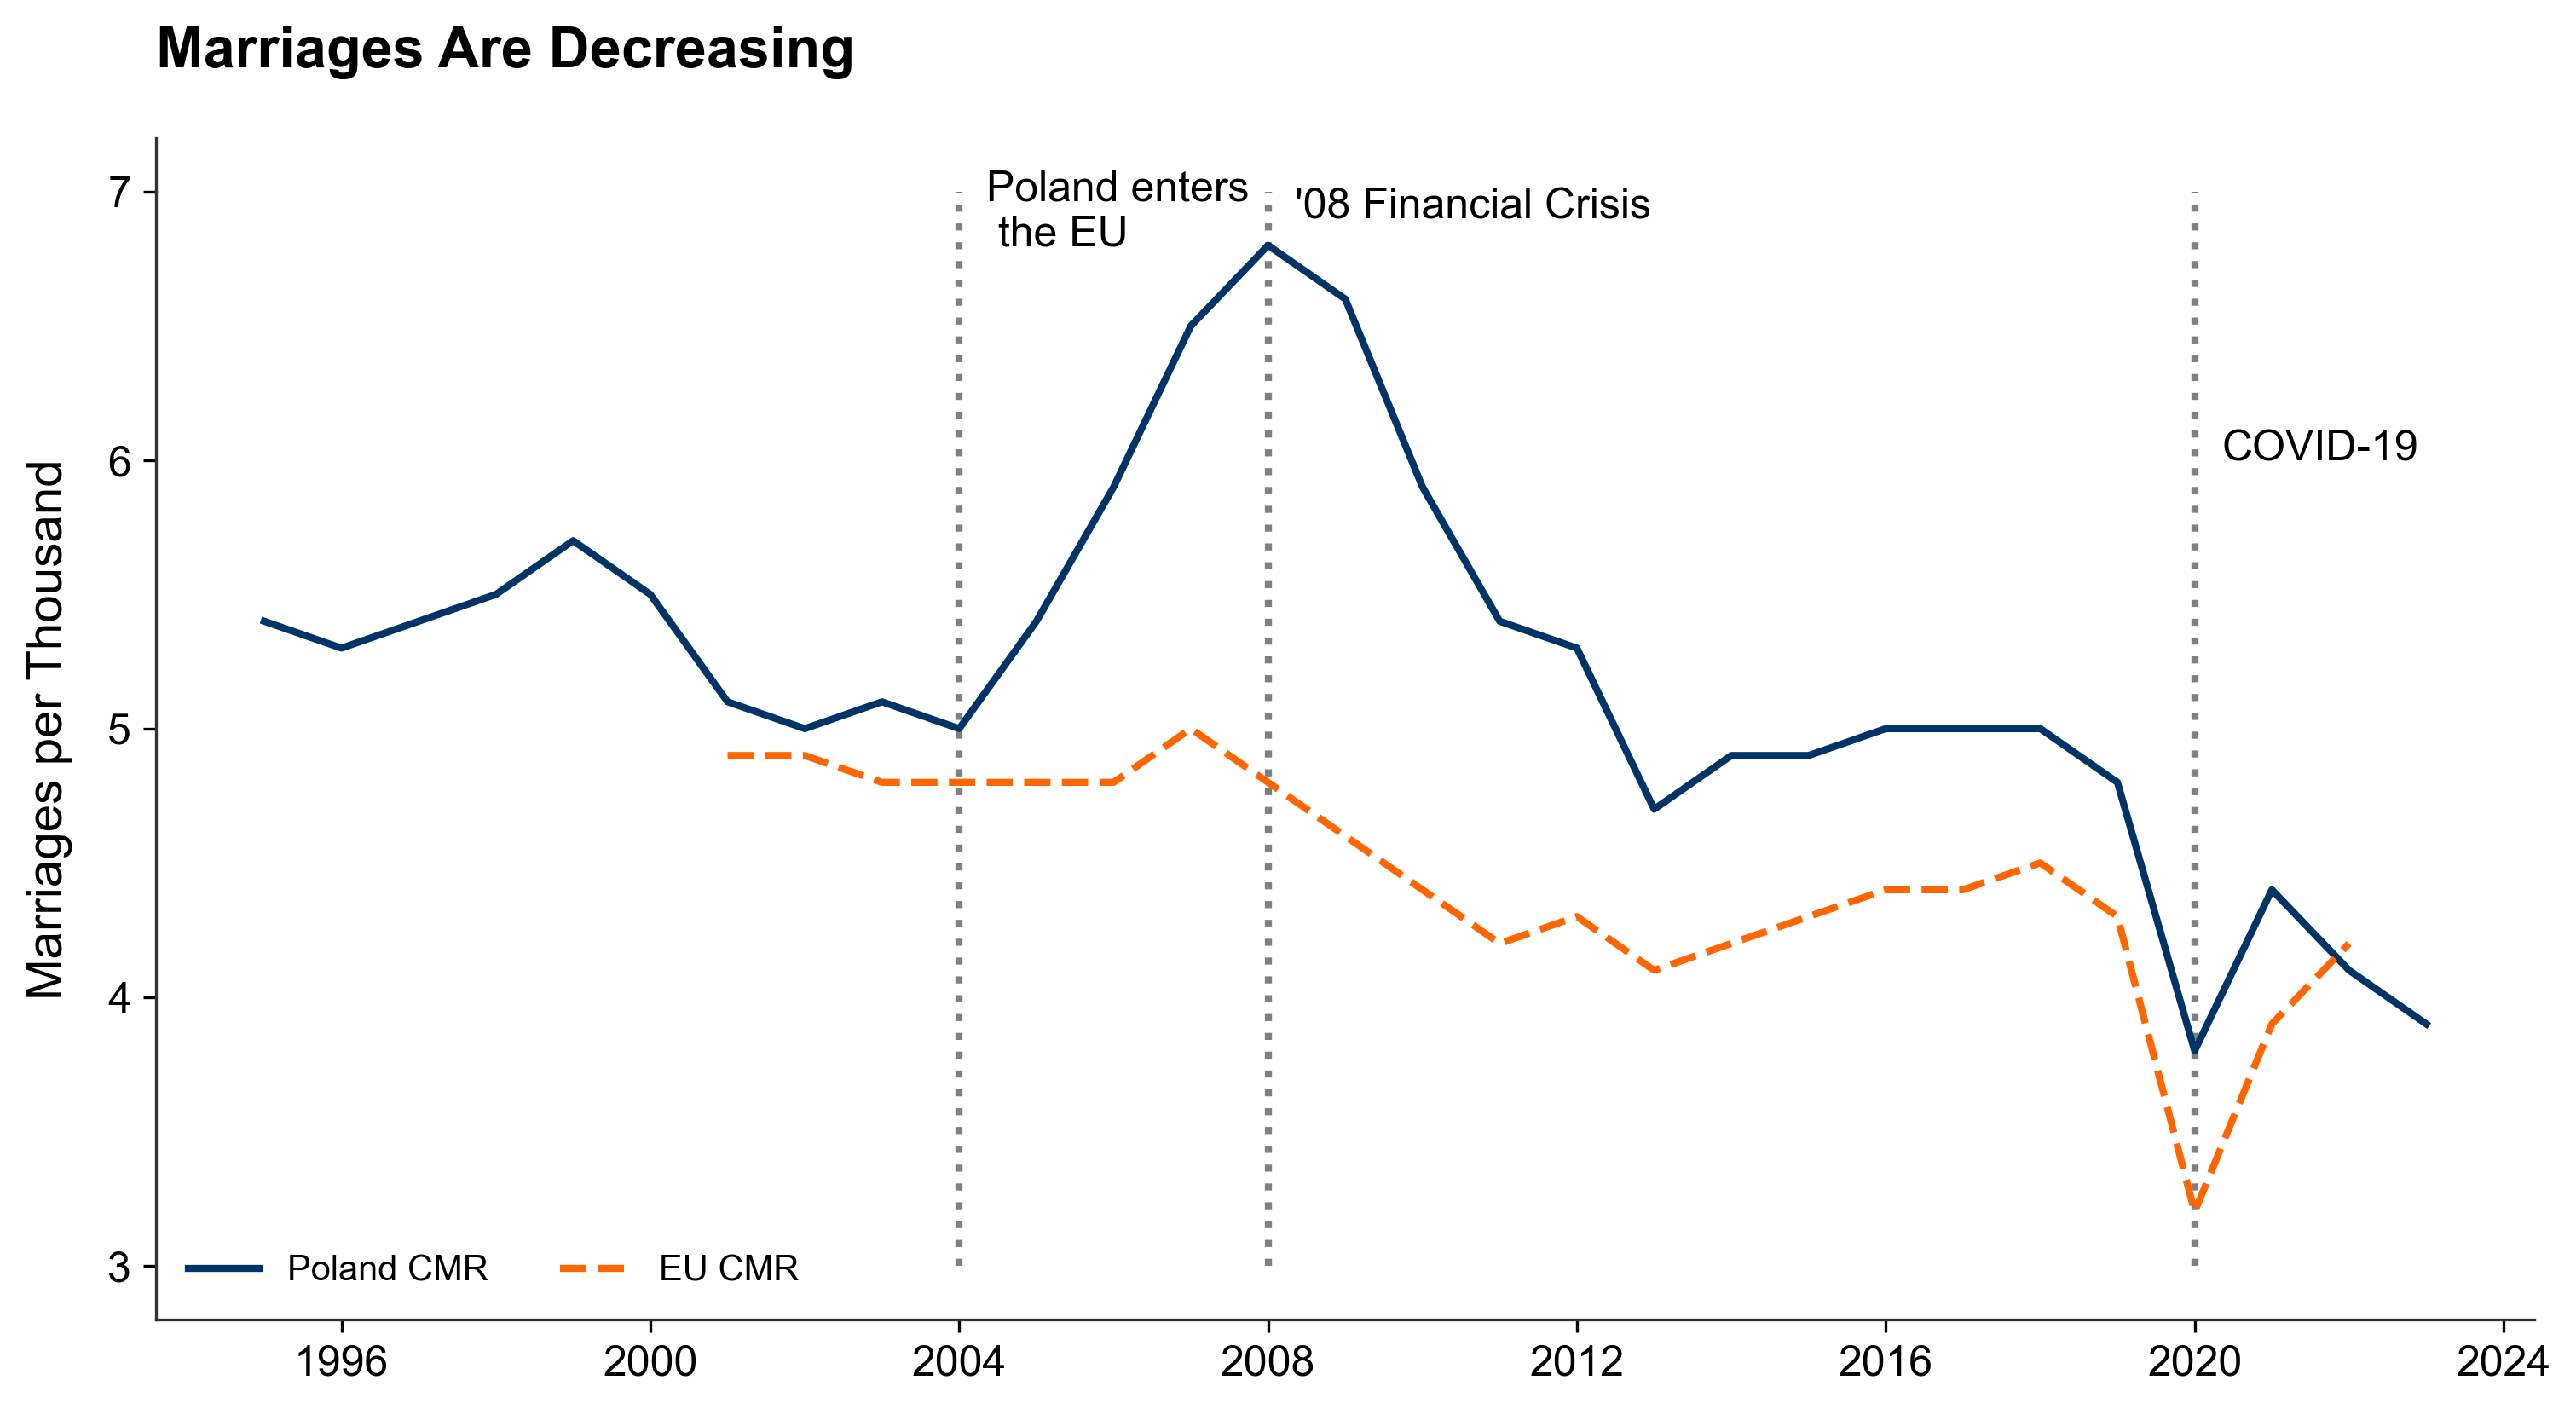

In [62]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(12,6))

# Axis Setup 
ax = plt.gca()

# Plots
sns.lineplot(df_cmr, x='year', y='cmr', label='Poland CMR', ax=ax)
sns.lineplot(df_cmr, x ='year', y ='eu_cmr', label= 'EU CMR', ax=ax, linestyle='--')

# Title Formatting
plt.title('Marriages Are Decreasing', loc='left', ha='left')

# Axis Formatting
plt.xlabel('')
ax.set_ylabel(ylabel='Marriages per Thousand', rotation = 90, fontdict={"fontsize":14})
ax.grid(False)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Legend Formatting 
lines_1, labels_1 = ax.get_legend_handles_labels()
legend = plt.legend(title='', loc='lower left', ncol=len(df_avg_age['gender'].unique()))
legend.get_frame().set_facecolor('none')
legend.get_frame().set_edgecolor('none')

# Vertical Lines 
events = [[2004,"Poland enters\n the EU", 6.80], [2008,'\'08 Financial Crisis', 6.90], [2020, 'COVID-19', 6.0]]

for event in events:
    plt.vlines(event[0], 3, 7, 'gray',':', label=event[1], zorder = 0)
    plt.text(x = event[0] + .35, y = event[2], s= event[1], fontdict={'fontsize':12})

plt.savefig('./charts/cmr.png')
# plt.show()

## Average Age of Marriage

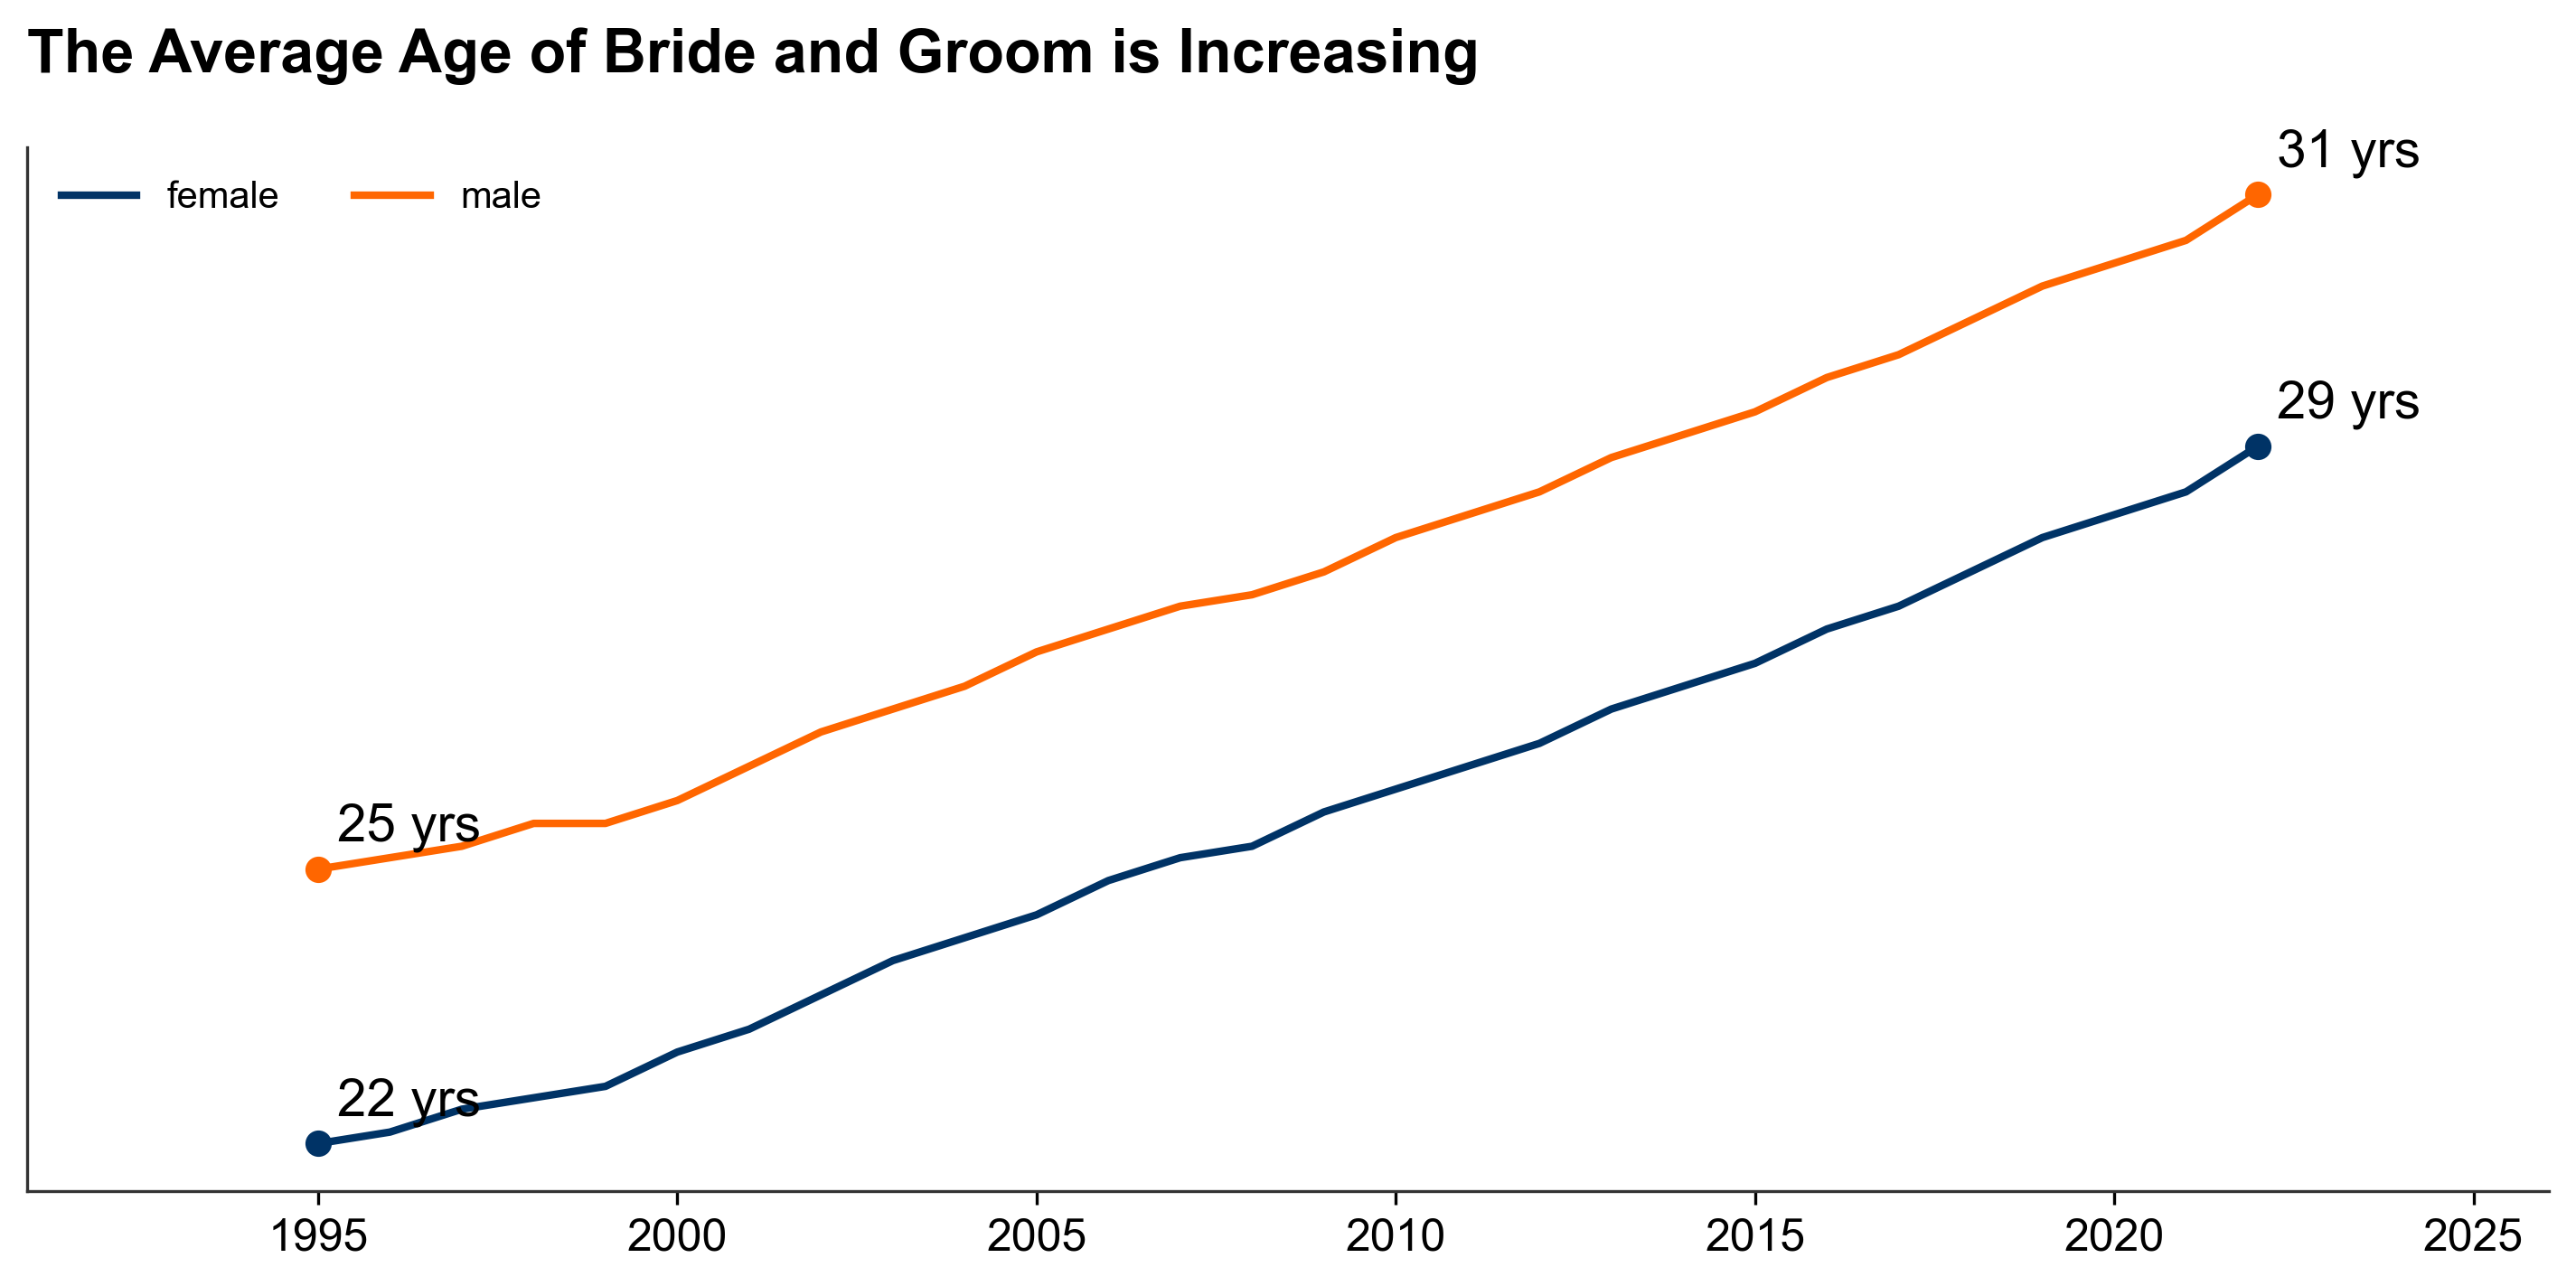

In [63]:
plt.figure(figsize=(12,5))

for gender in df_avg_age['gender'].unique():
    subset = df_avg_age[df_avg_age['gender'] == gender]
    plt.plot(subset['year'], subset['ave age'], label=gender)
    axis = plt.gca()
    axis.yaxis.set_visible(False)

    first_row = subset.iloc[[0]]  # Get the first row
    last_row = subset.iloc[[-1]]  # Get the last row
    
    # Combine them into a single DataFrame
    df_first_last = pd.concat([first_row, last_row])
    plt.scatter(df_first_last['year'], df_first_last['ave age'])

    for _, row in df_first_last.iterrows():
        text = plt.annotate(f"{row['ave age']:.0f}" + ' yrs',
                        xy = (row['year'], row['ave age']),
                        xytext =(5,11),
                        textcoords ='offset points',
                        ha='left', 
                        va='center',
                        fontsize =14
                        )
        
plt.gca().yaxis.set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# Legend
legend = plt.legend(title='', loc='upper left', ncol=len(df_avg_age['gender'].unique()))
legend.get_frame().set_facecolor('none') 
legend.get_frame().set_edgecolor('none') 

# Margins
plt.gca().margins(x=0.15)

# Labels
plt.xlabel('')
plt.ylabel('Average Age')
plt.title('The Average Age of Bride and Groom is Increasing', loc='left')

plt.savefig('./charts/average_age.png')
# plt.show()

## Marriages By Age Groups

In [64]:
custom_palette = {
    '<20': 'red',
    '20-24': '#e60049',
    '25-29': '#9b19f5',
    '30-34': "#0bb4ff",
    '35-39': "#ababab",
    '+40': 'grey'
}

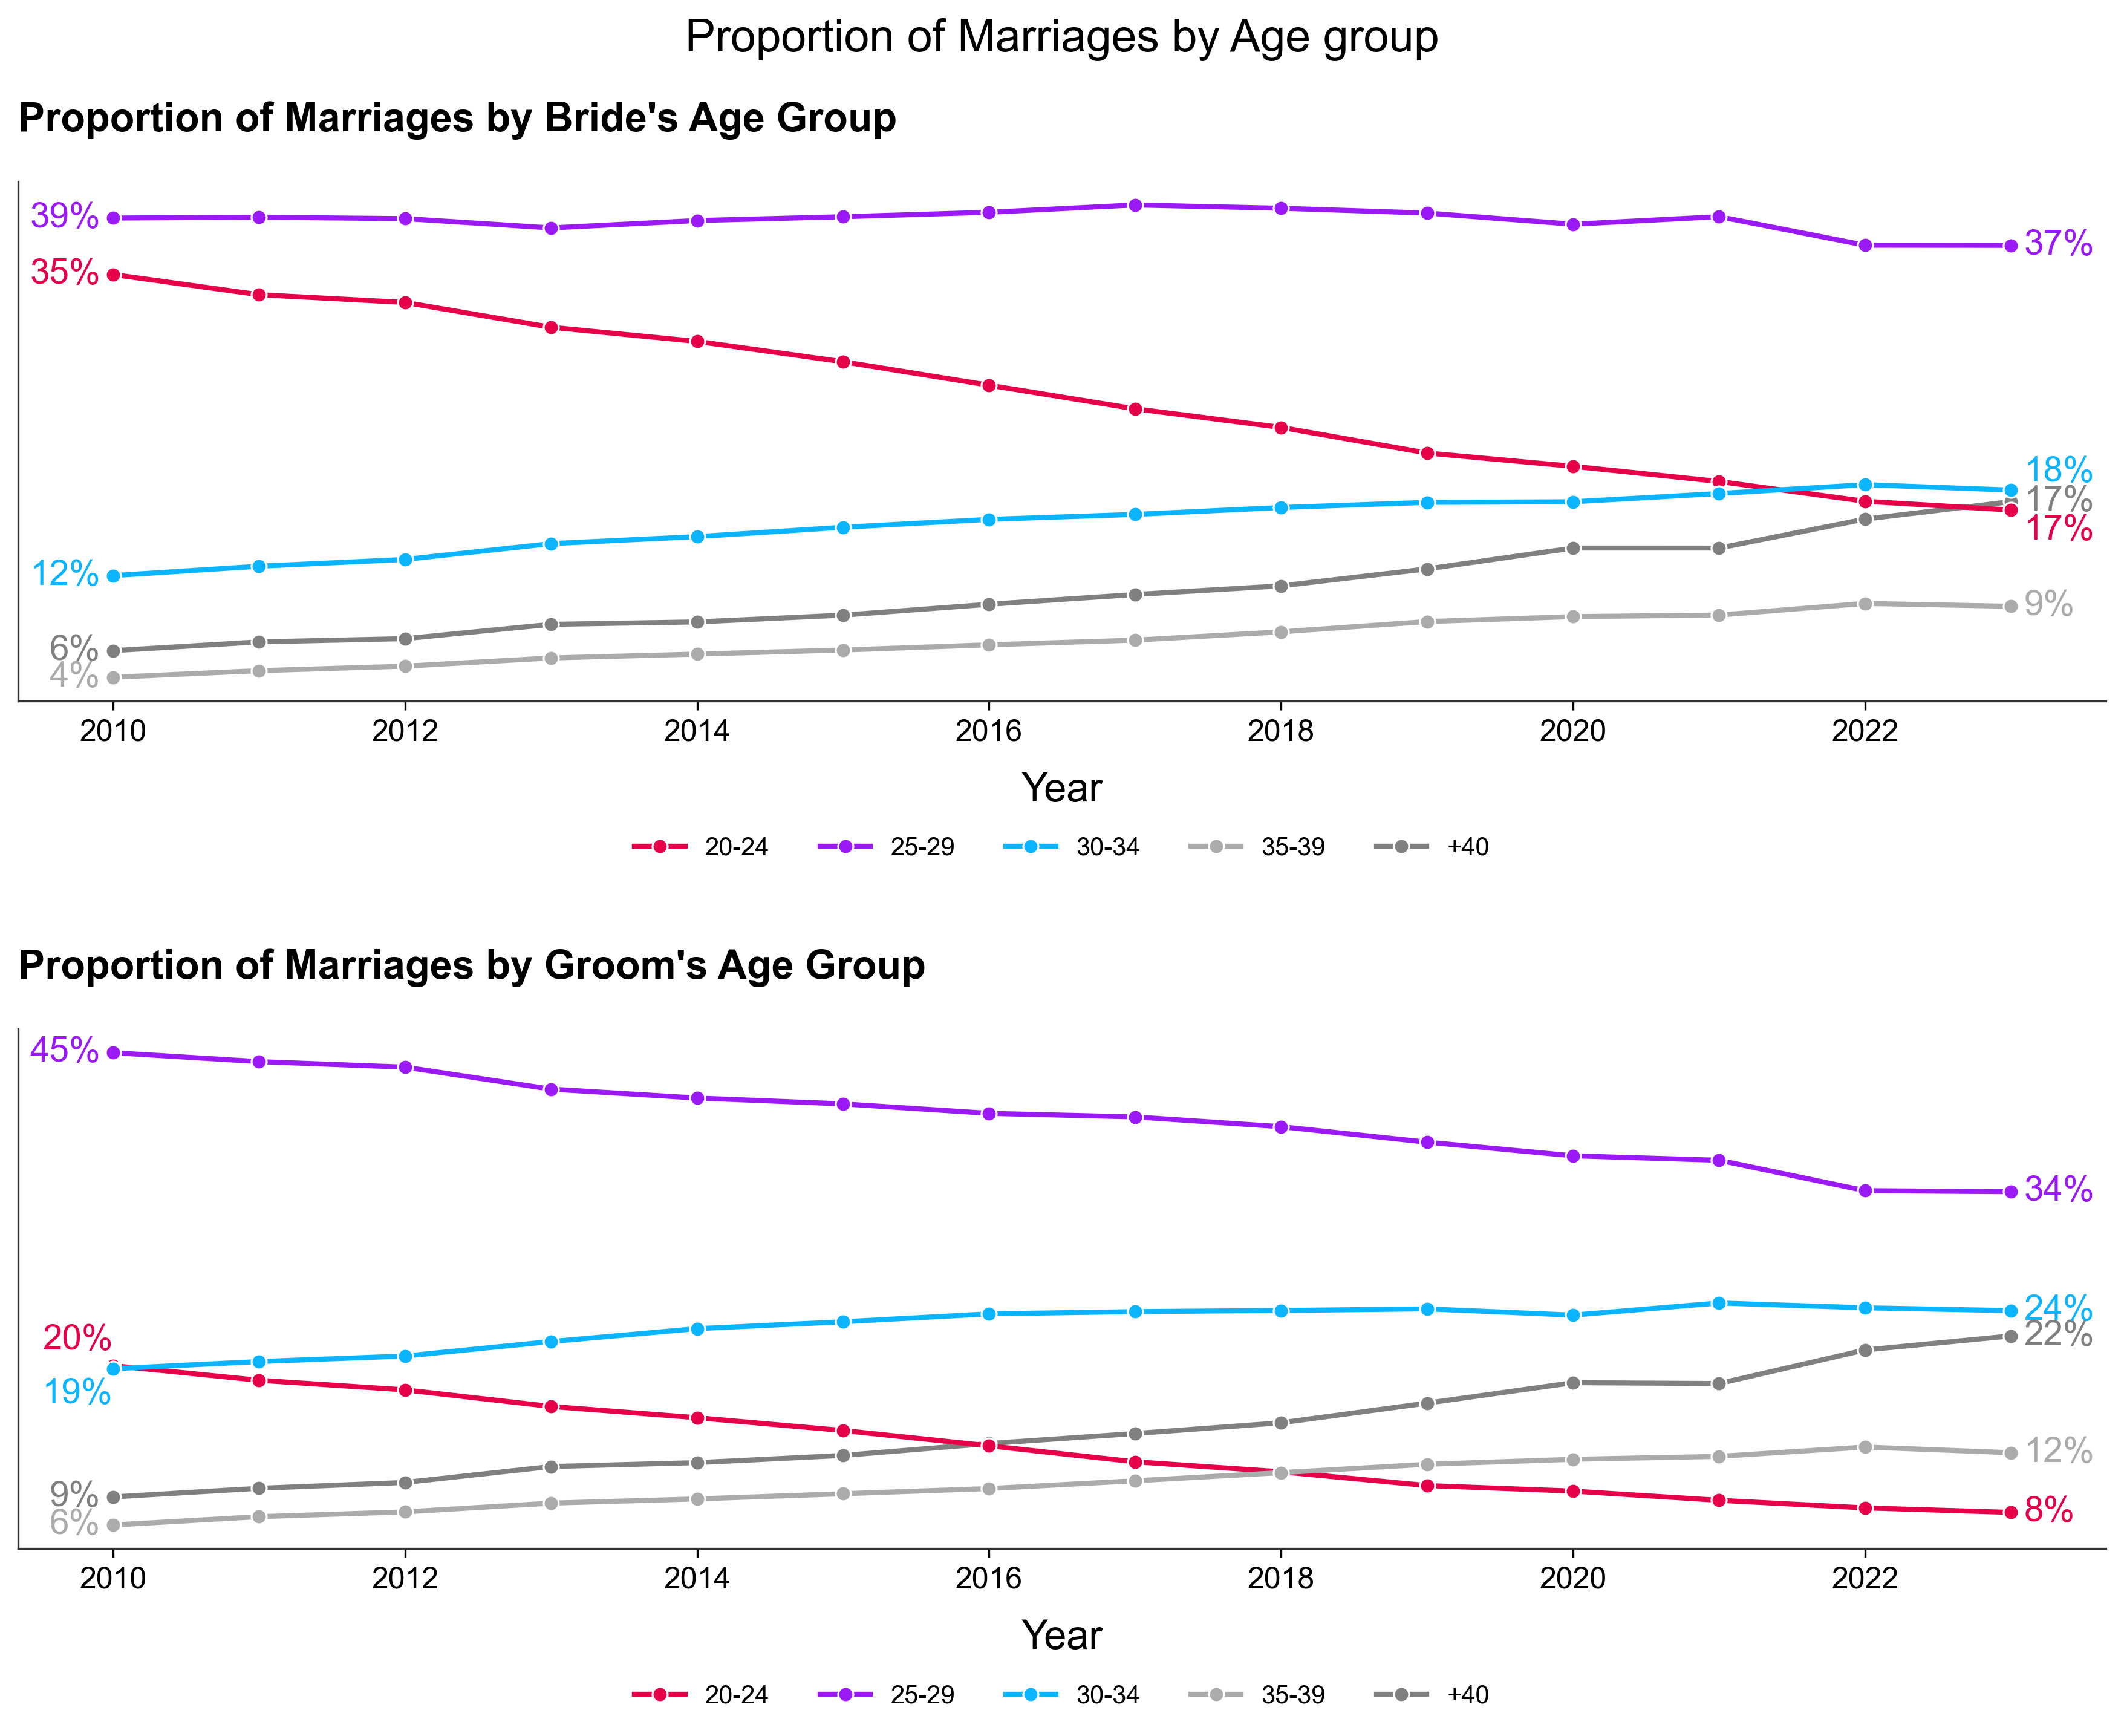

In [65]:
import matplotlib.ticker as mtick
fig, axes  = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Proportion of Marriages by Age group', fontsize = 18)

for i, gender in enumerate(df_marriage['gender'].unique()):

    df_temp = df_marriage[(df_marriage['gender'] == gender) & (df_marriage['age group'] != '<20')]

    sns.lineplot(df_temp, x='Year', y='percent of total', ax=axes[i], hue='age group', marker='o', palette=custom_palette)

    handles, labels = axes[i].get_legend_handles_labels()

    order = [1,2,3,4,0]
    axes[i].legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower center', bbox_to_anchor=(0.5, -0.35), fancybox=True, shadow=True, ncol = 5)
    axes[i].set_title("Proportion of Marriages by Bride's Age Group" if gender == "female" else "Proportion of Marriages by Groom's Age Group", loc='left')
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))  # Assuming 'Value' is in the range [0, 1]
    axes[i].set_ylabel('')  # Set y-axis label

    for age_group in df_temp['age group'].unique():

        df_group = df_temp[df_temp['age group'] == age_group]
        last_row = df_group.iloc[-1]
        first_row = df_group.iloc[0]

        xy_pos_last = (5,0)
        xy_pos_first = (-5, 0)

        # Manually adjusting the position of annotations
        if gender == 'female':
            if age_group == '20-24':
                xy_pos_last = (5,-8)
            elif age_group == '30-34':
                xy_pos_last = (5,7)

        if gender == 'male':
            if age_group == '20-24':
                xy_pos_first = (0, 10)
            elif age_group == '30-34':
                xy_pos_first = (0, -10)

        last_text = axes[i].annotate("{:.0%}".format(last_row['percent of total']),
                         xy = (last_row['Year'],last_row['percent of total']),
                         xytext = xy_pos_last,
                         textcoords = 'offset points',
                         ha = 'left',
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])

        first_text = axes[i].annotate("{:.0%}".format(first_row['percent of total']),
                         xy = (first_row['Year'], first_row['percent of total']),
                         xytext = xy_pos_first,
                         textcoords = 'offset points',
                         ha = 'right',
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])

for ax in axes:
    ax.set_yticks([])
    ax.yaxis.set_ticks_position('none')

plt.tight_layout()
plt.savefig('./charts/proportion_by_age.png')
# plt.show()

## CMR for Age Groups

In [66]:
df_grouped_cmr = pd.merge(df_marriage, df_pop, on='Year', how='left')
df_grouped_cmr = df_grouped_cmr.rename(columns={'Value_x':'total marriages', 'Value_y':'population'})
# We multiple by 10,000 instead of 1,000 so we have more readable values
df_grouped_cmr['group cmr'] = df_grouped_cmr['total marriages'] / df_grouped_cmr['population'] * 10_000


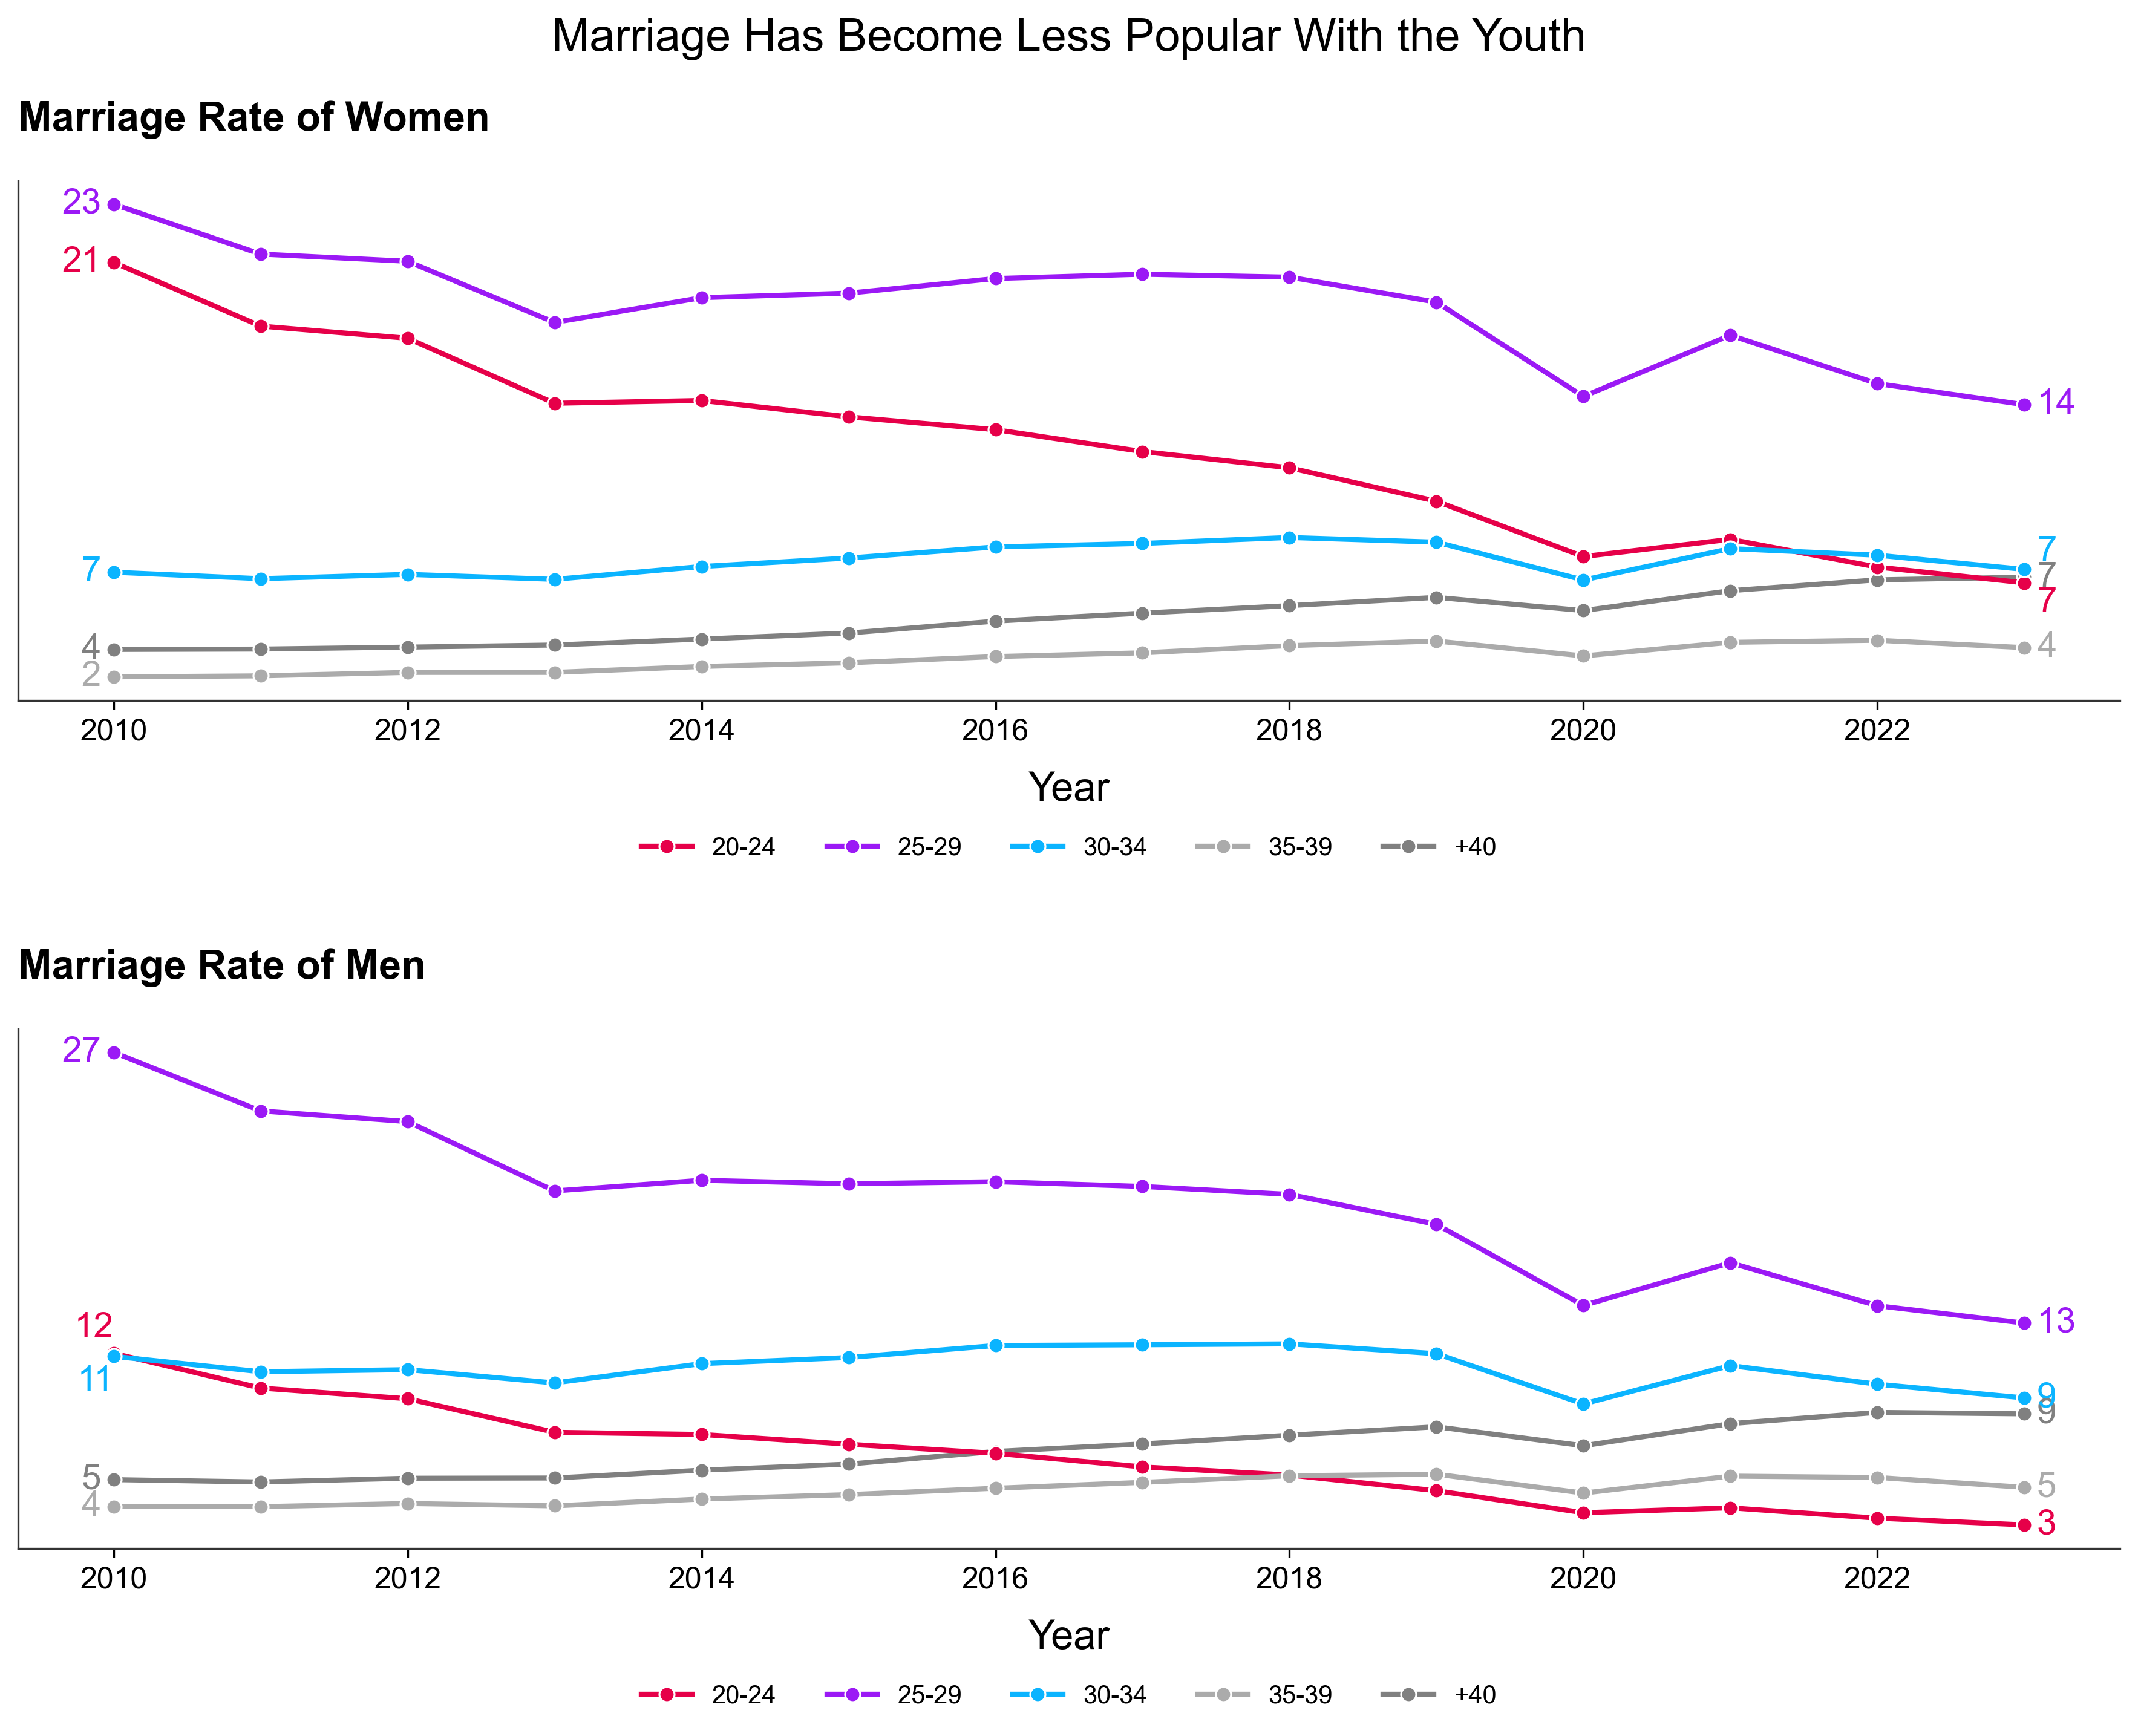

In [67]:
import matplotlib.ticker as mtick

fig, axes = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Marriage Has Become Less Popular With the Youth', fontsize = 18)

for i, gender in enumerate(df_grouped_cmr['gender'].unique()):
    df_temp = df_grouped_cmr[(df_grouped_cmr['gender'] == gender) & (df_grouped_cmr['age group'] != '<20')]

    sns.lineplot(df_temp, x='Year', y='group cmr', ax=axes[i], hue='age group', marker='o', palette=custom_palette)

    handles, labels = axes[i].get_legend_handles_labels()

    order = [1,2,3,4,0]
    axes[i].legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='lower center', bbox_to_anchor=(0.5, -0.35), fancybox=True, shadow=True, ncol = 5)
    axes[i].set_title("Marriage Rate of Women" if gender == "female" else "Marriage Rate of Men", loc='left')
    axes[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))  # Assuming 'Value' is in the range [0, 1]
    axes[i].set_ylabel('')  # Set y-axis label


    for age_group in df_temp['age group'].unique():

        df_group = df_temp[df_temp['age group'] == age_group]
        last_row = df_group.iloc[-1]
        first_row = df_group.iloc[0]

        xy_pos_last = (5,0)
        xy_pos_first = (-5, 0)

        if gender == 'female':
            if age_group == '20-24':
                xy_pos_last = (5,-8)
            elif age_group == '30-34':
                xy_pos_last = (5,7)

        if gender == 'male':
            if age_group == '20-24':
                xy_pos_first = (0, 10)
            elif age_group == '30-34':
                xy_pos_first = (0, -10)

        last_text = axes[i].annotate("{:.0f}".format(last_row['group cmr']),
                         xy = (last_row['Year'],last_row['group cmr']),
                         xytext = xy_pos_last,
                         textcoords = 'offset points',
                         ha = 'left',
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])

        first_text = axes[i].annotate("{:.0f}".format(first_row['group cmr']),
                         xy = (first_row['Year'], first_row['group cmr']),
                         xytext = xy_pos_first,
                         textcoords = 'offset points',
                         ha = 'right',
                         va = 'center',
                         fontsize = 14,
                         color = custom_palette[age_group])

# Hide y-axis labels and spine if desired
for ax in axes:
    ax.set_yticks([])  # Remove tick marks
    ax.yaxis.set_ticks_position('none')  # Ensure no ticks are

plt.tight_layout()
plt.savefig('./charts/cmr_by_age_group.png')

# Analysis

## The Changes in Marriage Rates
![average marriage age](charts/cmr.png)

Our chart shows that during times of positive or negative economic outlook, the marriage rates have grown or contracted. In 2004, Poland was admitted to the European Union and expectation where high about the benefits it would bring to the national economy. We can see a sharp increase in marriage rates until 2008, time of the 2008 Financial Crisis. Since the 2008 Financial Crisis, the marriage rate has been steadily decreasing, with a period of stability between 2014 and 2018. And, Unsurprisingly, we see a sharp drop in 2020, right as the COVID-19 Pandemic it at its highest point and continuing into 2023.

Interestingly, Poland faired comparatively well in the 2008 recession, with positive GDP growth consistent from 2009 to 2011 <sup>[2](https://tradingeconomics.com/poland/full-year-gdp-growth)</sup>. This is contrasted with the period from 2014 to 2018 GDP where growth was consistently above 3%, and crude marriage rate averaged held steady at roughly  5 marriages for every thousand people. We can infer that positive economic periods may be overshadowed by an individual's perception of economic security not to mention changes in society's attitude towards the importance of marriage. Although the exact sociological reasons would be more nuanced and is not within the scope of our analysis.

## Average Age of Bride and Groom
![average marriage age](charts/average_age.png)

A key indicator of societal attitude towards marriage is the average age at which people marry. In many Western and developed nations there has been a trend of postponing marriage to later stages of life. Many factors contribute to this, including the desire for financial security, a reduced importance of marriage and traditional relationships, and a perceived high cost of starting a family. 

Poland seemingly is following a similar trend, as the average age of marriage for men and women has steadily increased. On average Men are marrying six years later in life and women getting married seven years later than in previous decades. If this trends continues, then the next generation won't marry until their later thirties.

We will examine marriages by the specific age groups, to get a deeper insight of how perception or at least the desire to marry have changed over time.

## Proportion of Marriage by Age Group
![proportion of age group](charts/proportion_by_age.png)

#### Women
We can readily see the proportion of age group of 20-24 years old females has dropped quite significantly; by roughly 17 percentage points over the that last 14 years. This drop is not so surprising, considering trends that younger women continue to focus on higher education and career, and opting to start a family later in life. 

The age group of 25-29 on the other hand, still remains the popular age bracket for young women, seeing very little shift.

#### Men
For men the trend is very similar. Marriages by men in early twenties has dropped by 12 percentage points and late twenties by almost the same at 11 percentage points. 

Often, financial stability and career development are the primary reason why men are waiting until their thirties to begin a family. Other sociological factors come into play as well such as the change in attitudes toward traditional relationships.

## Issue With this Approach
A challenge with using the percentage of total marriages by age group is that the groups are not independent of each other; an increase in one group's proportions causes a decrease for the rest.

While this analysis is helpful at understanding an age group's _proportion_ of total marriages by by year, it does not accurately show a trend independent of any other group. 

One option is to plot the absolute number of marriages, but it does not account for changes in population overall. For example an increase in marriages for age groups 25-29 may be misleading if there was also a increase in the total population.

## CMR for Age Groups
To avoid these issues, we will use the crude marriage rate for each age group. This provides a more accurate comparison while compensating for any changes in population.

## Marriage Rates by Age Group 
![marriage rate by age group](charts/cmr_by_age_group.png)


## Ages 34 And Younger

For both men and women the number of marriages for age groups under 35 have dropped sharply over the last 14 years. Marriage rates for women dropped from 51 marriages to 25 a drop of 50%! The situation for men is nearly identical, with the marriage rate also dropping 50% from 50 to 25 marriages per 10,000 people. 

The overall decrease we've seen in the marriage rate in Poland has been driven by the youth of Polish society. 

# Findings
* The average age at time of marriage has been steadily increasing, with men and women getting married latter by roughly 6-7 years than the previous generation. 
* So our parents' generation married in their early twenties, our generation is getting married in their early thirties and if the trend continues our children won't get married until their late thirties!
* The decline in marriages is heavily influenced by a decline in the number of young men and women which has dropped by roughly 50% over the last decade. 